Simulating L=4...
Simulating L=8...
Simulating L=12...


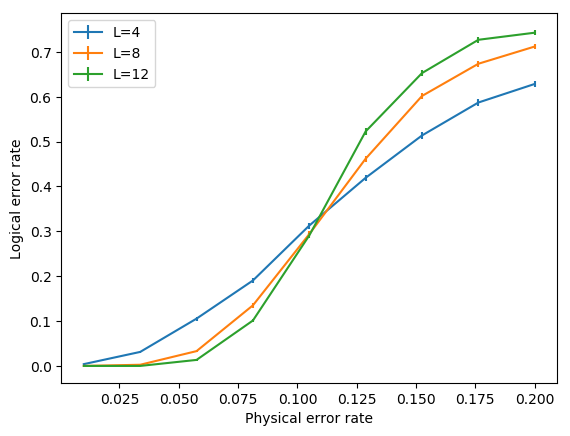

Simulating L=8...
Simulating L=10...
Simulating L=12...


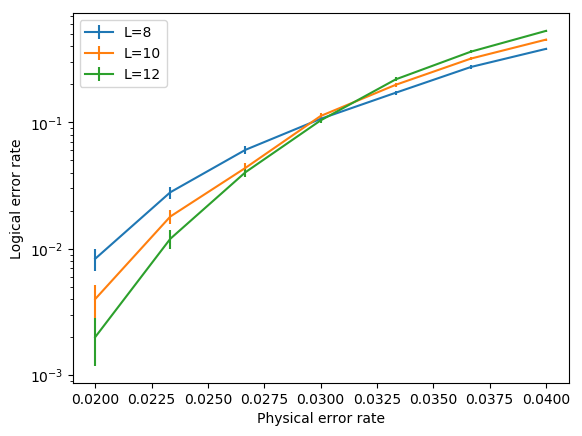

Simulating L=5...
Simulating L=9...
Simulating L=13...


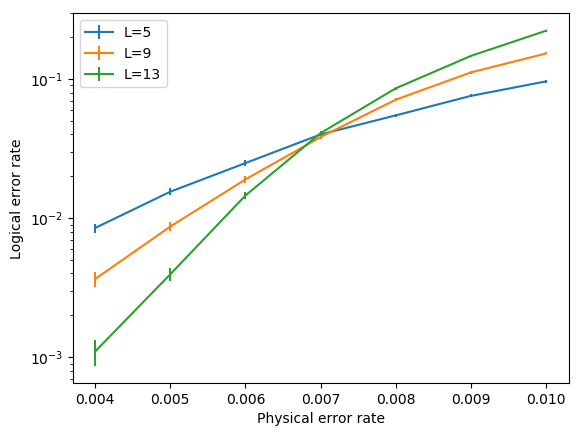

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack, kron, eye, csc_matrix, block_diag
from pymatching import Matching

def repetition_code(n):
    """
    Parity check matrix of a repetition code with length n.
    """
    row_ind, col_ind = zip(*((i, j) for i in range(n) for j in (i, (i+1)%n)))
    #print(row_ind)
    #print(col_ind)    
    data = np.ones(2*n, dtype=np.uint8)
    #print(data)
    return csc_matrix((data, (row_ind, col_ind)))


def toricXStabilizer(L):
    """
    Sparse check matrix for the X stabilisers of a toric code with 
    lattice size L, constructed as the hypergraph product of 
    two repetition codes.
    """
    Hr = repetition_code(L)
    H = hstack(
            [kron(Hr, eye(Hr.shape[1])), kron(eye(Hr.shape[0]), Hr.T)],
            dtype=np.uint8
        )
    #print("H = ", H)
    H.data = H.data % 2
    H.eliminate_zeros()
    return csc_matrix(H)





def decodingFailuresPhysicalFrameChanges(H, logicals, error_probability, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-error_probability)/error_probability))
    num_errors = 0
    for i in range(num_shots):
        noise = (np.random.random(H.shape[1]) < error_probability).astype(np.uint8)
        syndrome = H@noise % 2
        prediction = matching.decode(syndrome)
        predicted_logicals_flipped = logicals@prediction % 2
        actual_logicals_flipped = logicals@noise % 2
        if not np.array_equal(predicted_logicals_flipped, actual_logicals_flipped):
            num_errors += 1
    return num_errors





def numDecodingFailures(H, logicals, p, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-p)/p), faults_matrix=logicals)
    num_errors = 0
    for i in range(num_shots):
        noise = (np.random.random(H.shape[1]) < p).astype(np.uint8)
        syndrome = H@noise % 2
        predicted_logicals_flipped = matching.decode(syndrome)
        actual_logicals_flipped = logicals@noise % 2
        if not np.array_equal(predicted_logicals_flipped, actual_logicals_flipped):
            num_errors += 1
    return num_errors



def numDecodingFailures_vectorised(H, logicals, error_probability, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-p)/p), faults_matrix=logicals)
    noise = (np.random.random((num_shots, H.shape[1])) < error_probability).astype(np.uint8)
    shots = (noise @ H.T) % 2
    actual_observables = (noise @ logicals.T) % 2
    predicted_observables = matching.decode_batch(shots)
    num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
    return num_errors



#%%time

num_shots = 5000
Ls = range(4,14,4)
ps = np.linspace(0.01, 0.2, 9)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toricXStabilizer(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    for p in ps:
        num_errors = numDecodingFailures_vectorised(Hx, logX, p, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);
plt.show()


def numDecodingFailures_noisy_syndromes(H, logicals, p, q, num_shots, repetitions):
    matching = Matching(H, weights=np.log((1-p)/p),
                repetitions=repetitions, timelike_weights=np.log((1-q)/q), faults_matrix=logicals)
    num_stabilisers, num_qubits = H.shape
    num_errors = 0
    for i in range(num_shots):
        noise_new = (np.random.rand(num_qubits, repetitions) < p).astype(np.uint8)
        noise_cumulative = (np.cumsum(noise_new, 1) % 2).astype(np.uint8)
        noise_total = noise_cumulative[:,-1]
        syndrome = H@noise_cumulative % 2
        syndrome_error = (np.random.rand(num_stabilisers, repetitions) < q).astype(np.uint8)
        syndrome_error[:,-1] = 0 # Perfect measurements in last round to ensure even parity
        noisy_syndrome = (syndrome + syndrome_error) % 2
        # Convert to difference syndrome
        noisy_syndrome[:,1:] = (noisy_syndrome[:,1:] - noisy_syndrome[:,0:-1]) % 2
        predicted_logicals_flipped = matching.decode(noisy_syndrome)
        actual_logicals_flipped = noise_total@logicals.T % 2
        if not np.array_equal(predicted_logicals_flipped, actual_logicals_flipped):
            num_errors += 1
    return num_errors



num_shots = 3000
Ls = range(8,13,2)
ps = np.linspace(0.02, 0.04, 7)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toricXStabilizer(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    for p in ps:
        num_errors = numDecodingFailures_noisy_syndromes(Hx, logX, p, p, num_shots, L)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

    
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);   
plt.show()



import stim

num_shots = 20000
Ls = range(5,14,4)
ps = np.linspace(0.004, 0.01, 7)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    log_errors = []
    for p in ps:
        circuit = stim.Circuit.generated("surface_code:rotated_memory_x", 
                                        distance=L, 
                                        rounds=L, 
                                        after_clifford_depolarization=p,
                                        before_round_data_depolarization=p,
                                        after_reset_flip_probability=p,
                                        before_measure_flip_probability=p)
        model = circuit.detector_error_model(decompose_errors=True)
        matching = Matching.from_detector_error_model(model)
        sampler = circuit.compile_detector_sampler()
        syndrome, actual_observables = sampler.sample(shots=num_shots, separate_observables=True)
        predicted_observables = matching.decode_batch(syndrome)
        num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

    
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);
plt.show()

In [62]:
%matplotlib inline
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from qecsim import app
from qecsim.models.generic import BitFlipErrorModel
from qecsim.models.toric import ToricCode, ToricMWPMDecoder

# set models
codes = [ToricCode(*size) for size in [(3, 3), (5, 5), (7, 7), (9, 9)]]
error_model = BitFlipErrorModel()

error_model = CenterSliceErrorModel(lim=(0, 0, 1), pos = 1) # phase flip error        
#rng = default_rng()
#errorOnlyZ = 1
#while errorOnlyZ:
#error = my_error_model.generate(my_code, errRate, rng)

        
decoder = ToricMWPMDecoder()
# set physical error probabilities
error_probability_min, error_probability_max = 0, 0.2
error_probabilities = np.linspace(error_probability_min, error_probability_max, 11)
# set max_runs for each probability
max_runs = 1000

# print run parameters
print('Codes:', [code.label for code in codes])
print('Error model:', error_model.label)
print('Decoder:', decoder.label)
print('Error probabilities:', error_probabilities)
print('Maximum runs:', max_runs)

Codes: ['Toric 3x3', 'Toric 5x5', 'Toric 7x7', 'Toric 9x9']
Error model: Center-slice (lim=(0.0, 0.0, 1.0), pos=1)
Decoder: Toric MWPM
Error probabilities: [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2 ]
Maximum runs: 1000


In [63]:
# run simulations and print data from middle run to view format
data = [app.run(code, error_model, decoder, error_probability, max_runs=max_runs)
        for code in codes for error_probability in error_probabilities]
print(data[len(data)//2])

{'code': 'Toric 7x7', 'n_k_d': (98, 2, 7), 'time_steps': 1, 'error_model': 'Center-slice (lim=(0.0, 0.0, 1.0), pos=1)', 'decoder': 'Toric MWPM', 'error_probability': 0.0, 'measurement_error_probability': 0.0, 'n_run': 1000, 'n_success': 1000, 'n_fail': 0, 'n_logical_commutations': (0, 0, 0, 0), 'custom_totals': None, 'error_weight_total': 0, 'error_weight_pvar': 0, 'logical_failure_rate': 0.0, 'physical_error_rate': 0.0, 'wall_time': 0.7944639220004319}


In [64]:
code_to_xys = {}
for run in data:
    xys = code_to_xys.setdefault(run['code'], [])
    xys.append((run['physical_error_rate'], run['logical_failure_rate']))
print('\n'.join('{}: {}'.format(k, v) for k, v in code_to_xys.items()))

Toric 3x3: [(0.0, 0.0), (0.01972222222222222, 0.01), (0.03755555555555556, 0.024), (0.059222222222222225, 0.082), (0.08216666666666667, 0.165), (0.10177777777777777, 0.245), (0.122, 0.304), (0.13511111111111113, 0.354), (0.15944444444444444, 0.436), (0.17827777777777779, 0.515), (0.20183333333333334, 0.565)]
Toric 5x5: [(0.0, 0.0), (0.021079999999999998, 0.003), (0.04026, 0.018), (0.05908, 0.064), (0.07823999999999999, 0.133), (0.09978000000000001, 0.217), (0.11942, 0.336), (0.13938, 0.422), (0.15778, 0.495), (0.17764, 0.592), (0.20128000000000001, 0.649)]
Toric 7x7: [(0.0, 0.0), (0.019448979591836734, 0.0), (0.04046938775510204, 0.006), (0.05936734693877551, 0.037), (0.07943877551020408, 0.098), (0.0995204081632653, 0.238), (0.11935714285714286, 0.352), (0.13841836734693877, 0.495), (0.1601938775510204, 0.587), (0.17766326530612245, 0.649), (0.20077551020408163, 0.697)]
Toric 9x9: [(0.0, 0.0), (0.019660493827160494, 0.0), (0.040067901234567896, 0.006), (0.06176543209876543, 0.021), (0

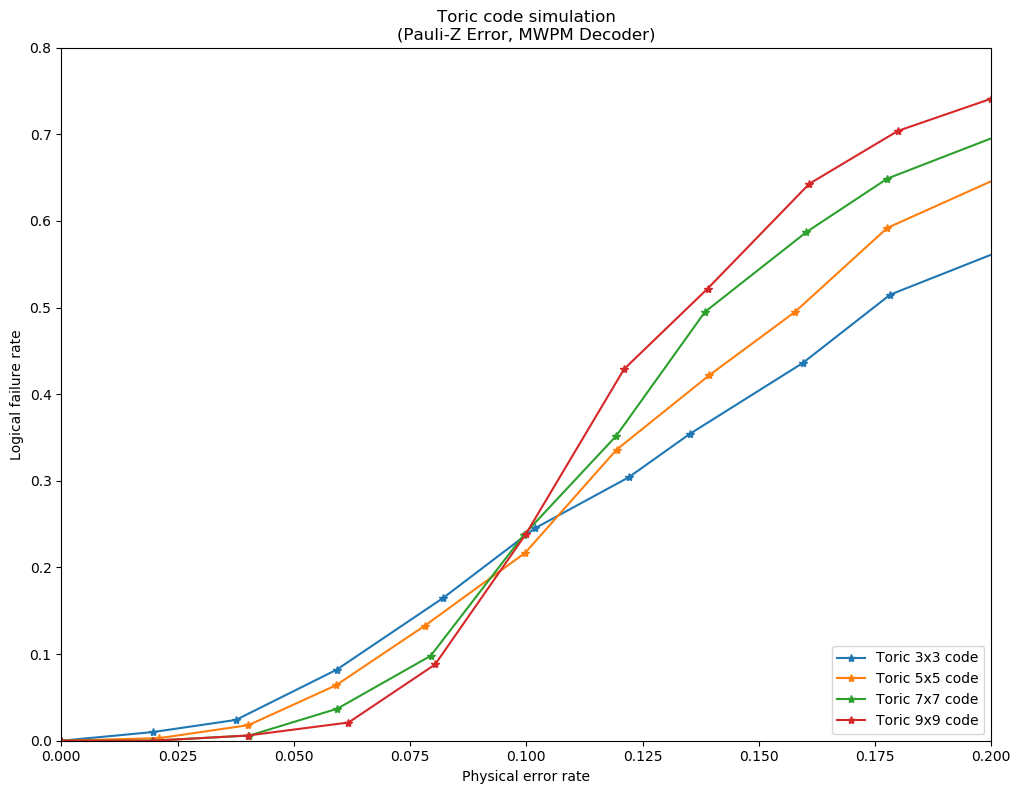

In [68]:
fig = plt.figure(1, figsize=(12, 9))
plt.title('Toric code simulation\n({}, {})'.format("Pauli-Z Error", "MWPM Decoder"))
plt.xlabel('Physical error rate')
plt.ylabel('Logical failure rate')
plt.xlim(0, 0.2)
plt.ylim(.0, 0.8)
# add data
for code, xys in code_to_xys.items():
    plt.plot(*zip(*xys), '*-', label='{} code'.format(code))
plt.legend(loc='lower right')
plt.savefig('ToricCodeMWPMZError3,5,7,9,11.png', dpi=450)
plt.show()    


In [53]:
import numpy as np
from qecsim import paulitools as pt
from qecsim.models.generic import DepolarizingErrorModel, CenterSliceErrorModel
from qecsim.models.toric import ToricCode, ToricMWPMDecoder

# initialise models
my_code = ToricCode(5, 5)
#my_error_model = DepolarizingErrorModel()
my_error_model = CenterSliceErrorModel(lim=(0, 0, 1), pos = 1) # phase flip error        
my_decoder = ToricMWPMDecoder()
# print models
print(my_code)
print(my_error_model)
print(my_decoder)

ToricCode(5, 5)
CenterSliceErrorModel((0.0, 0.0, 1.0), 1)
ToricMWPMDecoder()


In [55]:
error_probability = 0.1
# seed random number generator for repeatability
rng = np.random.default_rng()

# error: random error based on error probability
error = my_error_model.generate(my_code, error_probability, rng)
#rint("shape error = ", np.shape(error))
print("pauli error = \n{}".format(my_code.new_pauli(error)))

# syndrome: stabilizers that do not commute with the error
syndrome = pt.bsp(error, my_code.stabilizers.T)
#print("syndrome = ", syndrome)
#print("syndrome = \n{}".format(my_code.new_pauli(syndrome)))

recovery = my_decoder.decode(my_code, syndrome)
print("recovery ^ error = \n{}".format(my_code.new_pauli(error ^ recovery)))
syndromeAfter = pt.bsp(error ^ recovery, my_code.stabilizers.T)
if all(syndromeAfter==0):
    print("Stabilized")
#print("syndromeAfter = ", syndromeAfter)


pauli error = 
┼─·─┼─Z─┼─·─┼─Z─┼─·
·   ·   Z   ·   ·  
┼─·─┼─·─┼─·─┼─·─┼─·
·   ·   Z   ·   ·  
┼─·─┼─·─┼─·─┼─·─┼─·
·   ·   ·   ·   ·  
┼─·─┼─·─┼─·─┼─·─┼─Z
·   ·   ·   ·   ·  
┼─·─┼─·─┼─·─┼─·─┼─·
·   ·   ·   ·   ·  
recovery ^ error = 
┼─·─┼─Z─┼─·─┼─·─┼─·
·   Z   Z   ·   ·  
┼─·─┼─·─┼─·─┼─·─┼─·
·   Z   Z   ·   ·  
┼─·─┼─Z─┼─·─┼─·─┼─·
·   ·   ·   ·   ·  
┼─·─┼─·─┼─·─┼─·─┼─·
·   ·   ·   ·   ·  
┼─·─┼─·─┼─·─┼─·─┼─·
·   ·   ·   ·   ·  
Stabilized
